In [2]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

--2019-08-11 18:13:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
正在解析主机 archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
正在连接 archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：23715344 (23M) [application/x-httpd-php]
正在保存至: “Online Retail.xlsx”

Online Retail.xlsx  100%[===================>]  22.62M   114KB/s  用时 6m 42s    

2019-08-11 18:20:07 (57.6 KB/s) - 已保存 “Online Retail.xlsx” [23715344/23715344])



In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


以下是该数据集中字段的描述:
- InvoiceNo: 账单号，分配给每笔交易的唯一编号
- StockCode: 商品的代码。分配给每个不同商品的唯一编号
- Description: 商品描述
- Quantity: 每笔交易每种商品的数量
- InvoiceDate: 每笔交易日期和时间
- CustomerID: 消费者编号，分配给每个消费者的唯一编号

In [3]:
df.shape

(541909, 8)

## 处理缺失数据

In [4]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

由于我们有足够的数据，我们将删除所有缺少值的行。

In [5]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## 准备数据

让我们将StockCode转换为string数据类型:

In [6]:
df['StockCode']= df['StockCode'].astype(str)

让我们来看看我们的数据集中消费者的数量:

In [7]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

在我们的数据集中有4,372个消费者,对于这些消费者，我们将提取他们的购买历史。换句话说，我们可以有4372个购买序列。

留出数据集的一小部分用于验证是一个很好的方法。因此，我将使用90%消费者的数据来创建word2vec embeddings。让我们开始分割数据。

In [8]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

我们将在数据集中为训练集和验证集创建消费者购买的序列。

In [9]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:03<00:00, 1120.08it/s]


In [10]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1371.72it/s]


## 为商品构建word2vec Embeddings

In [11]:
# train word2vec model
model = Word2Vec(window = 10, 
                 sg = 1, 
                 hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, 
                 min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, 
            total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3615302, 3650510)

In [12]:
# save word2vec model
model.save("word2vec_2.model")

因为我们不打算进一步训练模型，所以我们在这里调用init_sims()。这将使模型的内存效率更高:

In [13]:
model.init_sims(replace=True)

In [14]:
print(model)

Word2Vec(vocab=3181, size=100, alpha=0.03)


我们的模型有3151个唯一的单词，每个单词的向量大小为100维。接下来，我们将提取词汇表中所有单词的向量，并将其存储在一个地方，以便于访问。

In [15]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3181, 100)

## 可视化word2vec Embeddings

可视化你所创建的embeddings是很有帮助的。在这里，我们有100维的Embeddings。我们甚至无法可视化4维空间，更不用说100维了，那么我们怎么做呢?

我们将使用UMAP算法将商品Embeddings的维数从100降到2，UMAP算法通常用于降维。

<Figure size 720x648 with 0 Axes>

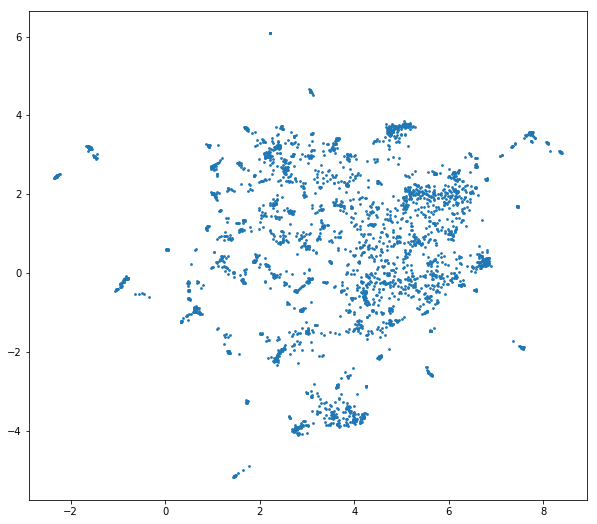

In [31]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, 
                              min_dist=0.0,
                              n_components=2, 
                              random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

这个图中的每个点都是一个商品。如你所见，这些数据点有几个很小的集群。这些是相似商品的组。

## 开始推荐商品

恭喜你!我们终于准备好我们的在线零售数据集中每个商品的word2vec embeddings 。现在，我们的下一步是为某个商品或某个商品的向量推荐类似的商品。

让我们首先创建一个商品id和商品描述的字典，以便轻松地将商品的描述映射到其id，反之亦然。

In [32]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [33]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

我定义了下面的函数。将一个商品的向量(n)作为输入，返回前6个相似的商品:

In [34]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

让我们通过传递商品编号为'90019A' (‘SILVER M.O.P ORBIT BRACELET’)的商品:

In [35]:
similar_products(model['90019A'])

[('BLUE MURANO TWIST BRACELET', 0.8339133262634277),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.795222282409668),
 ('GREEN MURANO TWIST BRACELET', 0.7638064026832581),
 ('SILVER LARIAT BLACK STONE EARRINGS', 0.7610573768615723),
 ('PINK BOUDICCA LARGE BRACELET', 0.7545701265335083),
 ('JADE DROP EARRINGS W FILIGREE', 0.7526347637176514)]

太酷了!结果还是非常相关，并且与输入商品匹配得很好。然而，这个输出仅基于单个商品的向量。如果我们想根据他或她过去的多次购买来推荐商品呢?

一个简单的解决方案是取用户迄今为止购买的所有商品的向量的平均值，并使用这个结果向量找到类似的商品。我们将使用下面的函数，它接收一个商品id列表，并返回一个100维的向量，它是输入列表中商品的向量的平均值:

In [36]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

回想一下，为了验证目的，我们已经创建了一个单独的购买序列列表。现在刚好可以利用它。

In [37]:
len(purchases_val[0])

196

用户购买的第一个商品列表的长度为314。我们将把这个验证集的商品序列传递给aggregate_vectors函数。

In [38]:
aggregate_vectors(purchases_val[0]).shape

(100,)

函数返回了一个100维的数组。这意味着函数运行正常。现在我们可以用这个结果得到最相似的商品:

In [39]:
similar_products(aggregate_vectors(purchases_val[0]))

[('SET OF 3 REGENCY CAKE TINS', 0.6918988823890686),
 ('SPOTTY BUNTING', 0.6808269023895264),
 ('JAM MAKING SET WITH JARS', 0.6781342029571533),
 ('PARTY BUNTING', 0.6656234264373779),
 ('SET OF TEA COFFEE SUGAR TINS PANTRY', 0.6611571311950684),
 ('SET OF 3 CAKE TINS PANTRY DESIGN ', 0.6589857935905457)]

结果，我们的系统根据用户的整个购买历史推荐了6款商品。此外，你也可以根据最近几次购买情况来进行商品推荐。

下面我只提供了最近购买的10种商品作为输入:

In [40]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('SET OF 3 REGENCY CAKE TINS', 0.6596167087554932),
 ('PACK OF SIX LED TEA LIGHTS', 0.6566801071166992),
 ('VINTAGE ZINC WATERING CAN', 0.6556558609008789),
 ('BISCUIT TIN VINTAGE CHRISTMAS', 0.6542550325393677),
 ('VINTAGE ZINC PLANTER  ', 0.653802752494812),
 ("3 RAFFIA RIBBONS 50'S CHRISTMAS ", 0.636172354221344)]

你可以随意修改这段代码，并尝试从验证集中的更多商品序列进行商品推荐。也可以进一步优化这段代码或使其更好。